# Machine Learning - Individual Assesment - University of the West of England
<a href="https://github.com/Sp0xF8/Individual-Project">GitHub Project Link</a>

# Imports

These libararies are used for all external functionality within the project.


## These imports are shared across the whole application and not specific to either model

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json 

import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV

from sklearn.impute import KNNImputer

## SVM Imports
<p>These imports are specifically related to the SVM's functionality</p>

In [73]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline

## ADA Ensambles
<p>These imports are specifically related to the ADA models</p>

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Getting the Data ready for interperating

## Loading the CSV Data

<p>In this stage we are using the Pandas libary to load the CSV data file.</p>
	<div style="margin-left: 20px;">
		<p>- This helps by giving us functionality to use a wide array of methods</p>
	</div>
<p>The data is then printed to allow for easy refencing and understanding of base data</p>


In [75]:
## Load the CSV file

data = pd.read_csv('diabetes.csv')

data[:]



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Splitting Features and Labels

While a small task, this step is crucial in allowing the model to learn the correct features. When models are trained, they look at every column of the data passed to them and attempt to find commonalities in relation to the classification options provided. In this project, simple **Binary Classification** is used. This means the decision is *between **1, True, Diabetic**, or **0, False, Non-Diabetic***. The model doesnt know how to distinguish between a entry that should be a feature, or a label. This means a manual split must be preformed, this affirms which colums are which to avoid confusion. 

In [76]:
# Creating the initial X and y lists from the data CSV file
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

## Initial Data Analysis

By looking at the table below, it is possible to see a few columns which have minimum values placed at 0. *This is true for **Glucose**, **Blood Pressue**, **Skin Thickness**, **Insulin** and **BMI***. This is concerning, as zero values for these features would indicate far worse problems than diabeties: ranging from pancretic failure to having died, or having no skin. If these values remain 0, they will adversly effect the preformance of the model. **Everyone should have a value for these features**. There are two options fro handeling these missing values. They could be deleted from the training set, *given the size is already smaller than preferred*, this is not preferencial. Additionally, *patients shouldnt be cast aside from the prediction algorithm simply because they only have one feature recorded*. 

The other way to handle missing data is through **Imputing**. There are many methods for imputing data, *the one focused on for this project is K-Nearest Neighbours (**KNN**)*. This involves taking each entry and plotting the distance between them, the missing features in each entry is then populated with the corrasponding feature values in the nearest neighbour. Ideally, all data points would already be complete:  imputing data allows you to simulate as if this were the case. This should help to provide more consistant results with the models.

It must be noted, ther are also zero values inside **Pregnancies**. *It is difficult to tell if these results were **not recorded**, or if they were **recorded as Zero***. There are a many number of reasons a patient *could conevievably never have been pregnant*, they could **not want kids**, or **not be able to become pregnant** through their sexual orientation or simply being the **wrong sex ($XY$, $XX$)**. Because of this, the data should not be imputed. Imputing Pregnancy data could result in harming the accuracy of the model, having **Zero pregnancies could be a relavent factor in classification**.


In [77]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


## Creating Storage Variables for Impution

This simple code is just used to store specific columns of the **X Data**.

**Pregnancies** is left untouched. This is used to store the entire "Pregnancies" column until impution has finished, as discussed, this data *should not be imputed*.

**No Pregnancy** is the data strcuture used to store all remaining columns. *These will be modified thoughout the impution process*. 

In [78]:
pregnancies = X["Pregnancies"]
no_pregnancy = X.drop("Pregnancies", axis=1)


no_pregnancy.isnull().sum()

Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

### Replacing Null Objects

As seen by the above printout of the sum of **Pandas.isnull** method, **there is already no data that needs imputing**: *according to the method*. The isnull function checks for explicit occurances of the NaN byte string, this is why values will continually return as being *already complete datasets*. 

It is assumed that the database used for storing the patient records will automatically set unassigned values to 0, instead of creating them as null objects. Given this, the Zeros in question must all be replaced by Null objects: allowing the *isnull* method to find them correctly. 

In [79]:
no_pregnancy.replace(0, np.nan, inplace=True)

no_pregnancy.isnull().sum()

Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

## Visualising Ratio of missing data

This simple function is used for displaying the amount of data missing in relation to the amount of data in each column. 

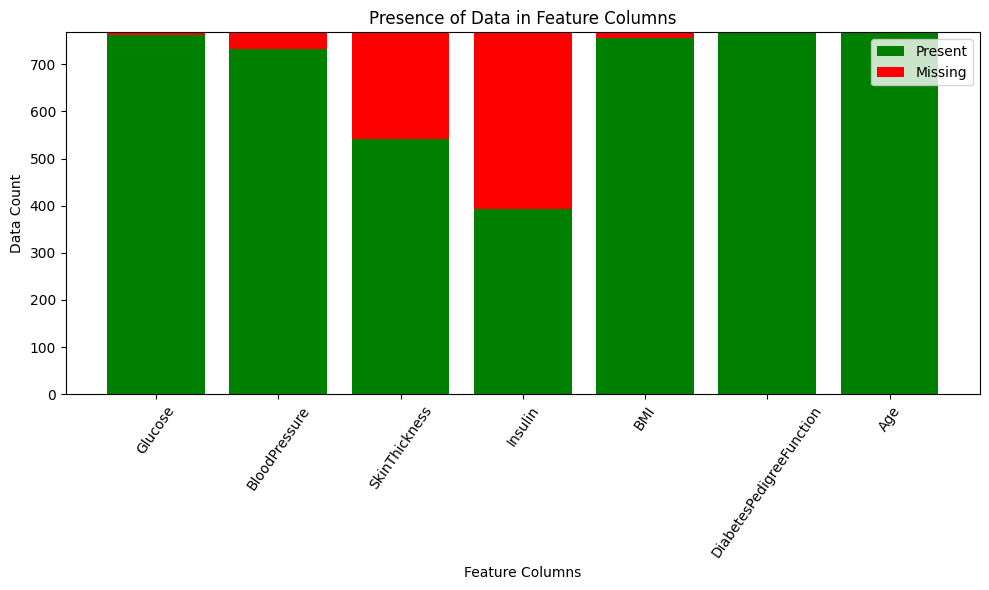

In [113]:
def visualised_missing_data(data):

	present_data = data.count()
	missing_data = len(data) - present_data

	# Plotting both present and missing data
	plt.figure(figsize=(10, 6))
	plt.bar(data.columns, present_data, color='green', label='Present')
	plt.bar(data.columns, missing_data, bottom=present_data, color='red', label='Missing')

	# Customizing plot
	plt.title('Presence of Data in Feature Columns')
	plt.xlabel('Feature Columns')
	plt.ylabel('Data Count')
	plt.xticks(rotation=55)
	plt.legend()
	plt.tight_layout()
	plt.show()


visualised_missing_data(no_pregnancy)

## Display Missing Data Frequency

This function is relativly simple and allows the operator to detect the specific locations and frequency of missing data within the structure. It takes two paramaters, the data structure for which to graph and a flag if the pregnancy column is included (the difference between 7 and 8 ticks on the x-axis). 

The heatmap colours chosen are designed to promote high contrast for people with colour-blindness, allowing whichever operator to easily understand without squinting. 

When data is detected as not being present: the existing data should have a colour of **yellow**, according to the colour bar's refernce for **1, Present**. The missing data should have a colour of **Dark Blue**.

When no data is detected as missing: the colour of existing data should be pink, as the only recorded value should be **1, Present**, this makes it the median value of the heatmap. 

In [81]:
def show_missing_data(data, flag=None):
	presence_matrix = ~data.isnull()

	# Plotting
	plt.figure(figsize=(20, 10))
	sns.heatmap(presence_matrix, cbar=True, cmap='plasma')

	if flag:	
		plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], labels=data.columns, ha='center', va='top', rotation=45)
	else:
		plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], labels=data.columns, ha='center', va='top', rotation=45)

	plt.xlabel('Feature Columns')
	plt.ylabel('Data Entries')
	plt.title('Location of (missing) Data in Feature Columns')
	plt.show()

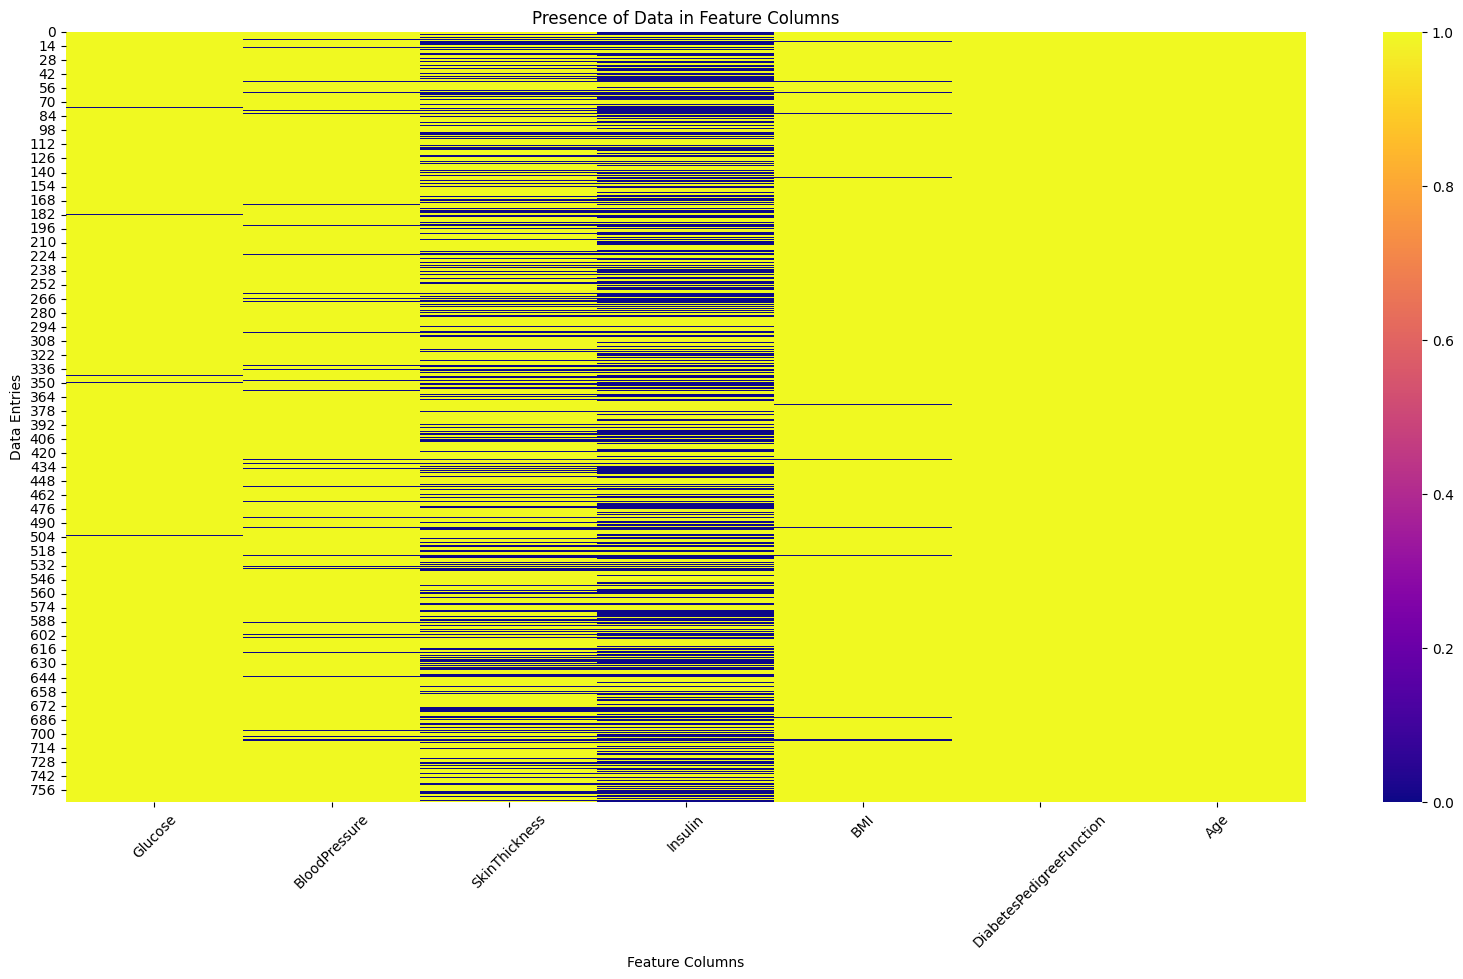

In [82]:
show_missing_data(no_pregnancy)

## Fill Missing Data Function

This simple function only acccepts one paramater, the *data structure **containing NaN objects***. This function then defines a local call to the **KNNImputer** function, provided by SKLearn. The data set is then imputed, after having trained the KNN model on the data. Finally, the imputed dataframe is returned. 

In [83]:
def fill_missing_data(data):
	imputer = KNNImputer(n_neighbors=7)

	data_filled = imputer.fit_transform(data)

	return pd.DataFrame(data_filled, columns=data_filled.columns)

## 

Total Missing Data:  0


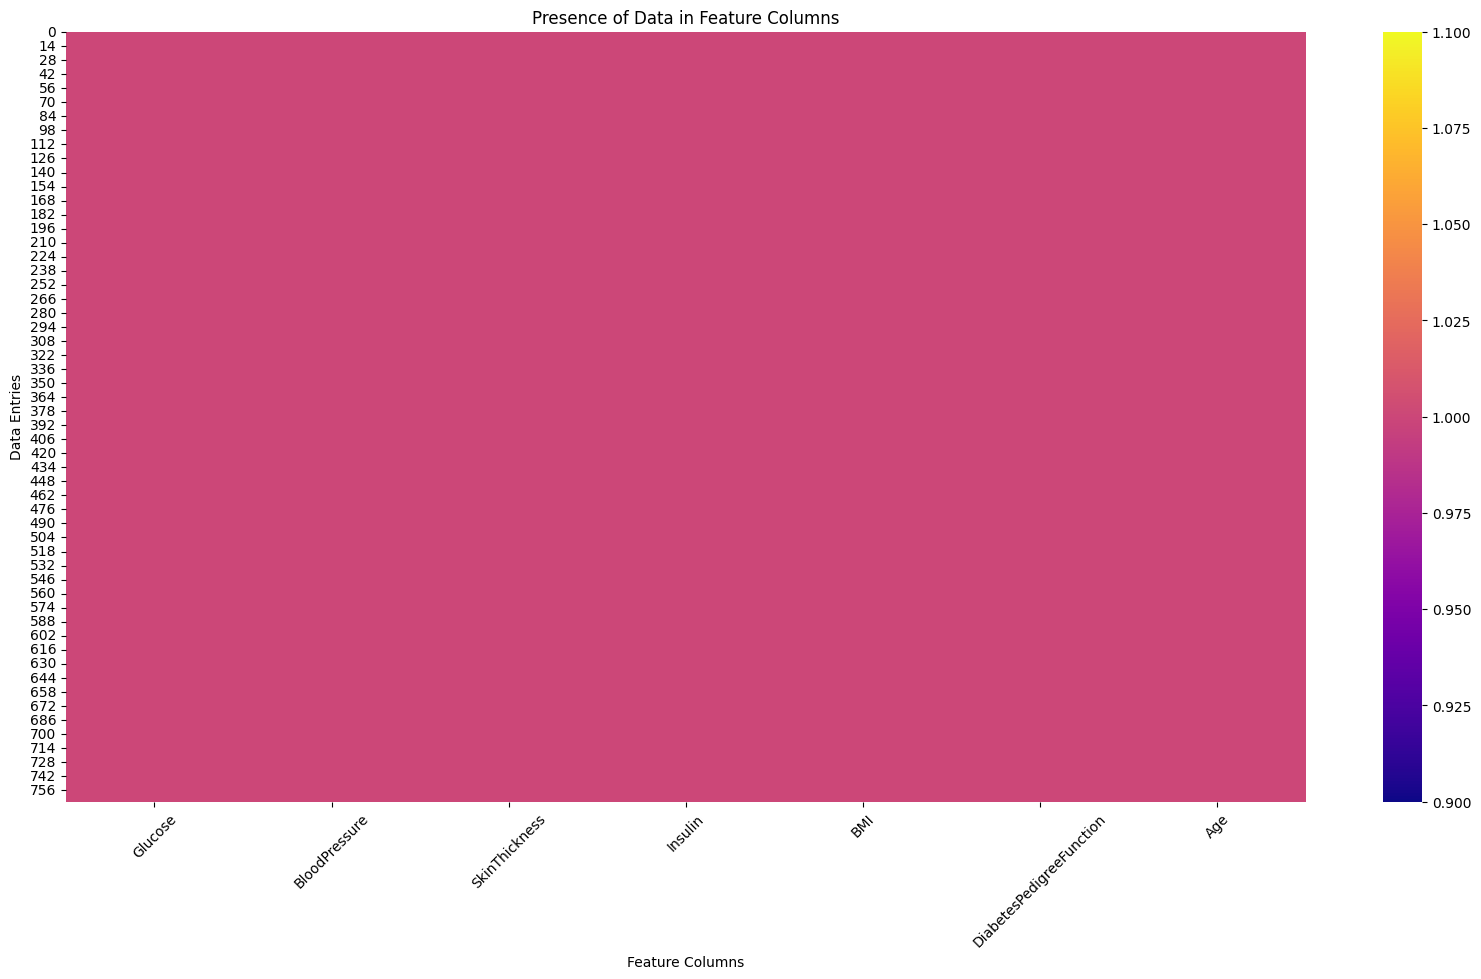

In [84]:
pure_data = fill_missing_data(no_pregnancy)


print("Total Missing Data: ", pure_data.isnull().sum().sum())
show_missing_data(pure_data)

## Reconstruct Finished data with Pregnancies

In [85]:
X = pd.concat([pregnancies, pure_data], axis=1)

## Splitting Test and Training Data

In Machine Learning, it is essential to split the dataset into training and test sets.
<div style="margin-left: 20px;">
	<p>The importance of having a <strong> Validation Dataset </strong> is having a selection of data for which the learned model will be scored against. By knowing the actual label of said inputs, it is possible to match them against the predictions made by the model. This is the most accurate way to test. A counter-option would be to test against the trained data, however this wouldn't be a real-world example of predicting <em>new labels</em>. Knowing the success rate of predicted models means the model can be adjusted until the preformance is satisfactory.
	</p>
</div>


Data is split into **80% Training Data**, and **20% Testing Data**. Both sets are comprised of a list of features and a list of labels. By splitting the data into 5ths, and using 4 of them for training: we are still providing a large enough dataset for training. This is important to keep track of. *Without having a large enough training set, **the model risks skipping some important distinctions** between the classes within the classification rules*. Equally, if the testing set is not large enough, it is difficult to make strong predictions about how the model has preformed. This is because, while successfuly predicting 2/3 and 66/99 classes correctly is the same radio: one has signifigantly more opertunity to fail its predictions. *Increasing this size, **while it doesnt improve the model**, gives a much better understanding as to how the model is preforming*.

Ideally, the Training Dataset would be much larger. This would give the Machine Learning models far more information from which to make predictions and would certainly provide a more stable prediciton result. Due to the limited size of the dataset, the standard best practice of a 75:25 split was reduced. *This was done in hopes of boosting the models ability to learn from more examples*. While this does result in a smaller Test set, **benefits of raising the Test Split size outweigh the drawbacks of not being able to provide a stronger preformance metric**. 

In [86]:
#split the data into training and testing data, 80% training and 20% testing- random state is set to 42 because it is the answer to everything
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setting up the Variables

## Creating SVM Variables
These two variables are of the type Dictonary, which is similar in format to the <strong>Json</strong> file extension. Advantages of setting the models to work in this behavoiur include ease of access and increased readability. It also gives the ability to store mulitple different datatypes in one element and easily export it to a Json file.
<div style="margin-left: 20px;">
	<p>
		<strong>svm_tests</strong> 			: This Dictonary is used to store the range of hyper-paramaters passed to the depth first grid search.
	</p>
	<p>
		<strong>current_svm_data</strong> 	: This Dictionary is used to store the current hyper-paramaters being passed to the <strong>svm_model</strong> class.
	</p>
</div>


In [87]:
# Dictionary to store the tests which will be preformed on the SVM
svm_tests = {
	'C': [7, 9, 11],
	'tollerance': np.linspace(0.0001, 0.1, 100),
	'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
	'max_iter': np.linspace(10, 10000, 100).astype(int),
	'decision_function_shape': ['ovo', 'ovr'],
	'possibility': [True, False],
}

# Dictionary to store the current test's data for the SVM
current_svm_data = {
	'kernel': None,#
	'max_iter': None,
	'decision_function_shape': None,#
	'probability': None,#
	'shrinking': None,#
	'C': None,
	'tollerance':None#
}

## Creating Ensambles Variables


Simiarly to the previous definitions, these variables are also of the type Dictionary. They are, instead, however multi-layered. 
<div style="margin-left: 20px;">
	<p>
		<strong>ada_ensambles_tests</strong> : This Dictonary is used to store the range of hyper-paramaters passed to the depth first grid search.
		<div style="margin-left: 50px;">
			<p>
				<strong>Estimator</strong> 			: This Dictonary is used to store the range of hyper-paramaters passed to the <strong>Random Forest Classifier</strong>.
			</p>
			<p>
				<strong>Params</strong> 			: This Dictionary is used to store the range of hyper-paramaters passed to the <strong>Ada Boost classifier</strong>.
			</p>
		</div>
	</p>
	<hr style="width:75%;" align="left">
	<p>
		<strong>current_ada_data</strong> 	: This Dictionary is used to store the current hyper-paramaters being passed to the <strong>ada_model</strong> class.
		<div style="margin-left: 50px;">
			<p>
				<strong>Estimator</strong> 			: This Dictonary is used to store the current hyper-paramaters being passed to the <strong>Random Forest Classifier</strong>.
			</p>
			<p>
				<strong>Params</strong> 			: This Dictionary is used to store the current hyper-paramaters being passed to the <strong>Ada Boost classifier</strong>.
			</p>
		</div>
	</p>
</div>


In [88]:
# Dictionary to store the tests which will be preformed on the AdaBoost Classifier and Random Forest Classifier
ada_ensambles_tests = {
	'Estimator': {
		'n_estimators': [50],
		'criterion': ['gini', 'entropy', 'log_loss'],
		'max_features': ['sqrt', 'log2'],
		'bootstrap': [True, False],
		'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
		'min_samples_leaf': [2, 3, 4, 5]
	},
	'Params': {
		'n_estimators': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
		'learning_rate': np.linspace(0.1, 3, 10),
		'algorithim': ['SAMME']
	}
}

# Dictionary to store the current test's data for the AdaBoost Classifier and Random Forest Classifier
current_ada_data = {
	'Estimator': {
		'n_estimators': None,
		'criterion': None,
		'max_features': None,
		'bootstrap': None,
		'min_samples_split': None,
		'min_samples_leaf': None
	},
	'Params': {
		'n_estimators': None,
		'learning_rate': None,
		'algorithim': None
	}
}

## Defining the test comparison
These two vairables are of type List and are used to store the best solutions found and their respective metrics. This is essneital in preforming a goal orientated depth first search. Without having a comparison, how can you know if you are finding a better solution?

<div style="margin-left: 20px;">
	<p>
		<strong>solution_list</strong> 		: This List stores class objects of the top 10 solutions, allowing for instant referencing once the search has been completed.
	</p>
	<p>
		<strong>accuracy_list</strong> 		: This List stores the accuracy of the class object at the same offset and is the list used for direct comparison without having to reference the solutions list; slowing down the, already hundreds of thousands, of tests. 
	</p>
</div>


In [89]:
solution_list = []
accuracy_list = []

# Ratios Function
This function is an easy way of returning multiple metrics in a more efficent way: using far less function calls.

### Paramaters:

<div style="margin-left: 20px;">
	<p>
		<strong>y_true</strong> 		: This variable is of type numpy array and holds the actual true values for the test data (<strong>y_test</strong>)
	</p>
	<p>
		<strong>y_pred</strong> 		: This variable is also of type numpy array and holds the predicted values for the test data (<strong>y_test</strong>)
	</p>
</div>

### Prediction Types:

<div style="margin-left: 20px;">
	<p>
		<strong>True Positive</strong> 		: This type of classification occurs when the model <em><strong>predicts a Positive result</strong>, and the result is <strong>actually Positive</strong></em>.
	</p>
	<p>
		<strong>True Negative</strong> 		: This type of classification occurs when the model <em><strong>predicts a Negative result</strong>, and the result is <strong>actually Negative</strong></em>.
	</p>
	<p>
		<strong>False Positive</strong> 	: This type of classification occurs when the model <em><strong>predicts a Positive result</strong>, and the result is <strong>actually Negative</strong></em>.
	</p>
	<p>
		<strong>False Negative</strong> 	: This type of classification occurs when the model <em><strong>predicts a Negative result</strong>, and the result is <strong>actually Positive</strong></em>.
	</p>
</div>



In [90]:
# Funct to test the SVM model without calling different functions, this is to make the code more readable and efficient
def ratios(y_true, y_pred):
    ## Get the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    ## Calculate False Negative Ratio
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
	## Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
	## Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
	## Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return fnr, recall, precision, specificity

# Class Definitions

Using a class instead of a standard function is highly effiecent. It allows for better reuseability, and storage, of data in the long term. This is fundamental concept of Object Orientated Programming. By using OOP in this project, it is much easier to rapidly cycle through a grid of hyper paramaters and subsequently output and results gained. This also means that less indents are reuqired to accomplish the same task, resulting in cleaner code which is much easier to understand.

By choosing to use a class, there is inherent access to standardised methods: like the constructor. Both the **svm_model** and **ada_model** both use **constructurs** which accept only one paramater. These are the previously defined respective Dictionarys (**current_svm_data**, **current_ada_data**). In this regard, the constructor is used to not only setup the Machine Learning model but also used to save paramaters. These can later be referenced by a different function, printing the best solutions found by the search. 

Additionally, the **predict** method is shared between the classes. While they both have vastly different features, they return the same metric values. The models themselves are stored in function-local variables, meaning once the predictions have been made: they are destroyed, freeing memory. The metric data is then stored in appropriatly named class-vairables for later use.

### Metric Variables:

<div style="margin-left: 20px;">
	<p>
		<strong>closed_pred</strong> 		: This is a variable of type Numpy Array and holds the <em>predicted true values for the test data</em> (<strong>y_pred</strong>)
	</p>
	<p>
		<strong>closed_accuracy</strong> 	: This variable is of the type Float and holds the most simple of the metrics. This is simply the number of <em>correctly classafied datapoints to the number of incorrectly classafied datapoints</em>. Having a good overall accuracy is important but, dependant on what application the model is used for, can be misappropriated.
	</p>
	<p>
		<strong>closed_precision</strong> 	: This variable is also of type Float and holds a ratio of <em>correctly identified <strong>True Positives</strong> to the total number of positive predictions</em> made by the model. This is useful for analysing the validity of the positivly predicited models. 
	</p>
	<p>
		<strong>closed_specificity</strong> : Similar to <strong>closed_precision</strong>, this variable is also Float. Instead, however, it stores the ratio of <em>correctly identified <strong>True Negatives</strong> to the total number of negative predictions</em> made by the model.  
	</p>
	<p>
		<strong>closed_recall</strong> 		: This variable type of Float is used for the <em><strong>Recall</strong>, or <strong>Sensitivity</strong>,</em> of the models predictions. This is <em>the number of <strong>True Positive</strong> predictions to the total number of positive instances</em>. Recall makes excellent pairing if <strong>closed_precision</strong> is also a metric of choice. It helps to give more complete info, as precision wil not specify how many instances were missed: only how accurate it is at finding positive predicitions. This could be misleading, as an easy way to always predict people with diabeties, without missing anyone, is to simply say <em>everyone has diabeties</em>. This would <strong><em>never miss a diabetic</strong>, but would <strong>instantly slow down formal diagnosis</strong> because everyone would be referred</em>.
	</p>
	<p>
		<strong>closed_fnr</strong> 		: This variable is of type float and holds the <em><strong>False Negative Ratio</strong></em>. This the invserse of <strong>Recall</strong>, however, for transparancy, using this as a clear metric seemed preferable. Often refered to as the <em>miss rate</em>, this metric is highly valued when missed positive instances is critical. When dealing with any form of diagnosis, it is far more important that the model can correctly identify as many <strong>True Positives</strong> as possible. <em>While it is <strong>less than ideal if a non-diabetic is referred</strong>, this would cause the diagnosis system to slow down, it is <strong>far more important that the diabetic is not overlooked</strong> and left without treatment</em>. It is important to note that <strong>this should not be the only metric used for judgement</strong>. A good choice of pairing for this metric would also be <em>Precision or Specificity</em>. Specificity would provide a well rounded overview by providing insight into if the model is simply predicting everyone as diabetic. 
	</p>
	<p>
		<strong>closed_f1</strong> 			: Of type Float, this variable stores the <em>harmonic mean of <strong>precision and recall</strong></em>. This ensures <strong>False Positives</strong> and <strong>False Negatives</strong> are accounted for, and is <em>particularly useful when neither have signifigantly different levels of importance</em>. Given the models previously stressed importance of not allowing for False Negatives, but having some leverage on False Positives: F1 scoring metrics are not entirely relavent. 
	</p>
</div>

### svm_model.predict Method

Typically, a prediction function would allow for some way of dynamically setting the data to be predicted. However, given the time complexity of the grid searches employed, it was far more efficent to define the test data globally and reference when needed. If this was to be progressed further, the predict function would need to take a multi-dimensional array as the input (representing the data to classify). For the current scenario, it is suited perfectly and offers an optimised solution.

Inside the prediction function, it begins by defining a pipline; through which, the data should be processed before reaching the **Support Vector Classifier**. Given the type of model, and the large separation of the data (*e.g pregnancies: 1, glocouse: 168), the data must be pre-processed before it can be accuratly analysed by the **SVC**. Problems can easily arise in the effectiveness of Linear based algorithms, this is where the **StandardScaler** is useful inside the pipline. Instead of predefining the the patient data (**X_train**, **X_test**, ...) after having been scaled, causing disruptions to the other ML model (**ada_model**), the data is scaled on access of the model. This means new test data added will also not need to be scaled, as the pipline will automatically handle any scaling needs. 

	closed_clf.fit(X_train, y_train)

This line of code is where the SVC Pipline is called to train the model. The first paramater, **X_train**, is then passed through the pipline. First being scaled, reducing the variance in the source data, then being passed further down the pipline to the SVC model and specified kernel. At its root, the **Standard Scaler** function is designed to help convert values from different formats into a single scale. It is designed to ensure that each feature has a mean of 0 and a unit of standard deviation. This is useful for Kernels such as *RBF*, which assumes that all features are centered around a 0 origin.

In [91]:

# SVM Model Definition
class svm_model:

	## Constructor - Takes in a data dictionary (current_svm_test) and assigns the values to the class variables
	def __init__(self, data):
		self.kernel 					= data['kernel']
		self.max_iter 					= data['max_iter']
		self.func_shape 				= data['decision_function_shape']
		self.probability 				= data['probability']
		self.shrinking 					= data['shrinking']
		self.tollerance 				= data['tollerance']
		self.C 							= data['C']



	## Predict Function - Uses the current_svm_test from the constructor to create a pipeline and predict the outcome of the test data 
	def predict(self):

		### Create the pipeline as a local variable
		closed_clf = make_pipeline(	
									StandardScaler(), # Standardise the data before training
									SVC( # Create the SVC model with the given parameters from the current_svm_test dictionary
										
										kernel=self.kernel, 
										max_iter=self.max_iter, 
										decision_function_shape=self.func_shape, 
										probability=self.probability, 
										shrinking=self.shrinking,
										C=self.C,
										tol=self.tollerance
									)
								)
		
		### Fit the model to the training data 
		closed_clf.fit(X_train, y_train)

		### Predict the outcome of the test data
		self.closed_pred 		= closed_clf.predict(X_test)

		### Calculate the accuracy, f1 score, false negative rate, recall, precision, and specificity of the model
		self.closed_accuracy 	= accuracy_score(y_test, self.closed_pred)
		self.closed_f1 			= f1_score(y_test, self.closed_pred)
		
		self.closed_fnr, self.closed_recall, self.closed_precision, self.closed_specificity	= ratios(y_test, self.closed_pred)

## ada_model.predict Method

### Random Forest Classifier
	closed_hype_clf = RandomForestClassifier(...)

1. At its basics, **Random Forest Classifier** is a combination of multiple decision trees, all trained from a different *randonly selected* datapoint. This simply involves choosing multiple random samples from the origonal dataset. These samples are then used to build trees from. 

2. At *each node of each decision tree*, a random number of features is selected (*so long as the value doesnt exceed **max_features***). This helps to ensure decision trees do not run in parralel, defeating the purpose of multiple trees. 

3. After a node has selected its features, within these selected features: the one which provides the best split, *according to the **criterion***, is chosen. 

4. The remaining data is then split into subsets based on the selected feature, creating different branches on the tree. This process is then repeated at each node until a stopping crietia is met.

5. After growing ***n_estimator*** number of trees, the results are aggrogated to make predictions. When these predicitons are made, each tree independently makes their own prediction. The final prediction for the *new input data, **X_test**, is the **average result of all of the trees***. 

### AdaBoost Classifier
	closed_clf = AdaBoostClassifier(closed_hype_clf, ...)

When you pass a Random Forest Classifier as an estimator to an AdaBoost Classifier, the AdaBoost algorithm works in conjunction with the Random Forest base estimator to create a strong ensamble model. Here's how it works:

1. The Random Forest Classifier is initialized as the base estimator within the AdaBoost. AdaBoost uses the Random Forest Classifier to build a sequence of weak learners.

2. AdaBoost trains multiple instances of the Random Forest Classifier, focusing more on the entities that were misclassified by the previous learners. This is achieved by adjusting the weights of the training entities during each iteration.

3. After training multiple Random Forest models, AdaBoost combines their predictions using a weighted voting system. The final prediction is determined from the weighted sum of individual Random Forest predictions, where the weight assigned to each model depends on its performance during training.

4. By iteratively focusing on difficult-to-classify entities and combining the predictions of multiple Random Forest models, AdaBoost enhances the overall performance of the ensamble classifier. This results in a robust and accurate model that utalises the strengths of both AdaBoost and Random Forest Classifiers.


As previously mentioned, data only needs to be scaled for models which assume the data is centered around a 0 point. Neither of these classifiers do, meaning the data can be left in its standard form. This is because they make choices based on relative values, not absolute. As mentioned, they choose splits which maximise information gain: but the splits are made independently within features, meaning no scale conflicts either.



In [92]:

# SVM Model Definition
class ada_model:

	## Constructor - Takes in a data dictionary (current_svm_test)
	def __init__(self, current_test):

		## Assign the values from the current_test dictionary to the class variables, which are also dictionaries. this removes the outer layer, improving readability later on
		self.clf_estimator = current_test['Estimator']

		self.clf_params = current_test['Params']
		

	## Predict Function - Uses the current_svm_test from the constructor to create an AdaBoost Classifier and a Random Forest Classifier to be used as an estoimator to predict the outcome of the test data
	def predict(self):

		### Create the estoimator for the AdaBoost Classifier as a local variable 
		closed_hype_clf = RandomForestClassifier(
									n_estimators=self.clf_estimator['n_estimators'], 
									criterion=self.clf_estimator['criterion'],
									max_features=self.clf_estimator['max_features'], 
									bootstrap=self.clf_estimator['bootstrap'],
									min_samples_split=self.clf_estimator['min_samples_split'], 
									min_samples_leaf=self.clf_estimator['min_samples_leaf'], 
									n_jobs=-1
								)
			
		### Create the AdaBoost Classifier as a local variable with the given parameters from the current_svm_test dictionary
		closed_clf = AdaBoostClassifier(
							closed_hype_clf,
							n_estimators=self.clf_params['n_estimators'],
							learning_rate=self.clf_params['learning_rate'],
							algorithm=self.clf_params['algorithim'],
							random_state=1)
		
		### Fit the model to the training data
		closed_clf.fit(X_train, y_train)

		### Predict the outcome of the test data
		self.closed_pred 		= closed_clf.predict(X_test)

		### Calculate the accuracy, f1 score, false negative rate, recall, precision, and specificity of the model
		self.closed_accuracy 	= accuracy_score(y_test, self.closed_pred)
		self.closed_f1 			= f1_score(y_test, self.closed_pred)
		self.closed_fnr, self.closed_recall, self.closed_precision, self.closed_specificity	= ratios(y_test, self.closed_pred)

# Helper Functions

### Convert to Serialisable
This simple helper function takes an entity as a paramater and returns it, after having been converted to a JSON serialisable type. Given the only abstract type being used is a **Numpy Int32**, there only needs to be one conditional. Every other type can be converted at base value.  

In [93]:
def convert_to_serialisable(ent):
    if isinstance(ent, np.int32):
        return int(ent)
    return ent

### Write JSON

While it would have been entirely possible to use the the classes default __dict__ function, this gives little control over the how the results are displayed: decreasing readabaility. It is true, given the JSON file extnesion, the data could simply be extracted and accessed in a more appropriate way. But it made more sense to provide a file that is also legible to a human aswel. This means that the user could quickly take a look at the results manually, without having to decypher the cryptic positioning of the variables within the dictionary.

Additionally, it would have also been possible to store the array as an array. However, given the length of the array: it seemed more logical to include it as a string, creating a row instead of a 100 line column. This also makes direct comparison between predictions and expected results much easier as they run in paralel.

#### Paramaters:
<div style="margin-left: 20px;">
	<p>
		<strong>class_name</strong> 		: This paramater should either be an <strong>svm_model</strong> or <strong>ada_model</strong>. 
	</p>
	<p>
		<strong>output_file</strong> 		: This paramater should be of type <strong>string</strong> and <em>finish with a ".json" file extension</em>. It will not create an error if a txt is used, but some json functionality could be limited.
	</p>
</div>

In [94]:
def write_json(class_name, output_file):
	
	## Create a dictionary to store the class variables and the results of the model
	class_dict = {
		"features": {# Dictionary created empty, to be filled with the features of corresponding model.
		},
		"results": { # Dictionary used to store the metrics of the model 
			"accuracy": class_name.closed_accuracy,#float
			"f1": class_name.closed_f1,#float
			"fnr": class_name.closed_fnr,#float
			"recall": class_name.closed_recall,#float
			"precision": class_name.closed_precision,#float
			"specificity": class_name.closed_specificity#float
		},
		"predictions": { # Dictionary used to store the predictions of the model
			"y_pred": str(class_name.closed_pred.tolist()),#array as string
			"y_true": str(y_test.tolist())#array as string 
		}
	}

	## Check if the class_name is an instance of the svm_model class
	if(isinstance(class_name, svm_model)):
		class_dict["features"] = { # If the class_name is an instance of the svm_model class, fill the features dictionary with the features of the model
			"kernel": str(class_name.kernel),#str
			"max_iter": class_name.max_iter,#int
			"decision_function_shape": str(class_name.func_shape),#str
			"probability": class_name.probability,#bool
			"shrinking": class_name.shrinking,#bool
			"tollerance": class_name.tollerance,#float
			"C": class_name.C#float
		}
	elif(isinstance(class_name, ada_model)):
		class_dict["features"] = { # If the class_name is an instance of the ada_model class, fill the features dictionary with the features of the model
			"Estimator": {
				"n_estimators": class_name.clf_estimator['n_estimators'],#int
				"criterion": str(class_name.clf_estimator['criterion']),#str
				"max_features": str(class_name.clf_estimator['max_features']),#str
				"bootstrap": class_name.clf_estimator['bootstrap'],#bool
				"min_samples_split": class_name.clf_estimator['min_samples_split'],#int
				"min_samples_leaf": class_name.clf_estimator['min_samples_leaf']#int
			},
			"Params": {
				"n_estimators": class_name.clf_params['n_estimators'],#int
				"learning_rate": class_name.clf_params['learning_rate'],#float
				"algorithim": str(class_name.clf_params['algorithim'])#str
			}
		}

	_tojson_ = json.dumps(class_dict, default=convert_to_serialisable, indent=4) # Convert the class_dict to a JSON string

	with open(output_file, 'a') as f: # Open the output file in append mode and write the JSON string to the file

		f.write(str(_tojson_ ) + ',\n') # Add a comma and a newline character to the end of the JSON string to separate the different tests
		

### Solution Comparison

This is quite a simple function. It checks that **closed_precision** is lower than 70%, then proceeds to compare the current test against the current Top 10 solutions found. If a new best solution is found, the **solution_list** and **accuracy_list** are appended respectivly. The solution is then written to the correctly named JSON file. If the length of the list exceeds 10 items, the item at the front of the list is removed. 

#### Paramaters:
<div style="margin-left: 20px;">
	<p>
		<strong>current_test</strong> 	: This paramater should either be an <strong>svm_model</strong> or <strong>ada_model</strong>. 
	</p>
	<p>
		<strong>solution_name</strong> 	: This paramater should be of type <strong>string</strong> and <em>finish with a ".json" file extension</em>. It will not create an error if a txt is used, but some json functionality could be limited.
	</p>
</div>

In [95]:
def check_worst(current_test, solution_name):

	if (current_test.closed_precision < 0.7):
		return

	## for each solution in the solution list, where i stores the current solution being compared to the current test
	for i in range(len(solution_list)):

		## cbeck if the current test's preformance metric is more optimal than the current solution's preformance metric
		if (current_test.closed_fnr < accuracy_list[i] or current_test.closed_fnr < 0.34):
			## append the current test to the solution list and the accuracy of the current test to the accuracy list
			solution_list.append(current_test)
			accuracy_list.append(current_test.closed_fnr)

			## write the current test to the output file
			write_json(current_test, solution_name)


			## check if the length of the solution list is greater than 10
			if(len(solution_list) > 10):
				## pop the first element from the solution list and the accuracy list
				solution_list.pop(0)
				accuracy_list.pop(0)

			return

# Systematic Grid Search

**SKLearn** deos include a standard grid search function: *GridSearchCV*. It is described as an "*exhaustive* search" over a definied paramater list. First it trains each possibility of **hyperparamaters** and scores them, using the most admirable for the final predictions. This function is ***increably exhaustive*** when searching over a large dataset. Instead of preforming an optimised search, this algorithm aims to save all possibilities in memory. This would be insignifigant when only checking a few hundred tests. However, with the hundreds of millions of combinations: **how do you know which to test**? 

It is possible to use the GridSearchCV function for these millions of test paramaters, however the computational requirements are *linear to the **number of tests** $*$ **memory usage for the model selected***. This can easily cause any computer to come to a grinding hault and freeze, even possibly resulting in a BSOD error. The *optimal memory usage should be **memory usage for the model selected** $*$ **number of best solutions***. For this search, as seen in the *Comparison Function*, the max number of best solitions to be stored in active memory should not exceed the number of best solutions, *10*, and an additional solution for the one being tested. This gives a *final memory usage of **11** $*$ **memory usage for the model selected***.

Given the memory optimisation of the custom search functions, it would be possible to preform searches on computers with limited memory availability. Dependent on the speed of the computer, and the size of the test, this could still take days to analyse for the most optimal hyperparamaters: however, in theory it should only need to run once as all best solutions found are stored in an external data-structure. **More will be spoken about that later**, but the key benefits of searching in this style is that it gives *functionalty to find the best paramaters inside of an **infinitly large pool of paramaters***. That is, ***so long as you have enough time to wait***. 

This is a deal breaker for the health industry, whos computer power usually lags behind civilisation due to lack of funding.

## Grid Search Functions

Both of these functions are structured in the same way for simplistic calling conventions, they also use the same logic: giving exceptions for differences needed by the individual model.

Whent he function is called, a few new *local varaibles* are defined. **iterationCount** is inconsequential to the flow of the actual search, however does it allows the program operator to see how many tests have been completed. This is used in combination with the **number_of_tests** constant, which is calculated by multiplying the length of all of the hyper paramater arrays together. These are later used to give a direct number of tests remaining, affirming to the operator: *tests are still being executed*. 

Next, the **Best Solutions** output is prepared. A new file is created in the JSON file format and a singular bracket and newline is written. This allows the different, best solutions, to be indexed and referenced as independent dictionarys. The final stage of preperation occurs when pushing an empty solution and the worst possible score for the model to acheive. This kick-starts the solution comparison, without it there is nothing to compare against and nothing to iterate. Because this data is added to the respective lists directly, there they will not be outputted to the **Best Solutions**. Neither will they be output to the **Best 10 Solutions**, the first few tests will overwite them no *matter how good they actually are*: the initial push is relativly much worse.

Finally, the bullk of the functions. Both are rooted on the principle: multiple nested for loops, incrementally cycling through the test paramaters held by **data**. These values are passed to the relative model's dictionary which is then subsequently passed to the class instance reprenting the Machine Learning model chosen. The prediction function is then called, on termination the class is passed to the *Comparison Function*. 

On completion of each itteration, an addition macro is applied to the **iterationCount** variable so that the completion percentage of the search can be accuratly seen. Every time the algorithm completes one inner loop: the **Iterations** TXT is overwritten.

Once the entire search as been completed, a final closing bracket is added to the **Best Solutions**. Finally, the **Best 10 Solutions** are produced.

### Paramaters:
<div style="margin-left: 20px;">
	<p>
		<strong>data</strong> 	: This paramater should be of type Dictionary and should hold the <strong>svm_tests</strong>, or <strong>ada_ensambles_tests</strong>. 
	</p>
</div>

### Outputs:
<div style="margin-left: 20px;">
	<p>
		<strong>Best Results</strong> 	: This output will be in the JSON file format and <em>will be generated, <strong>only  on completion of the entire search</strong></em>.
	</p>
	<p>
		<strong>Results</strong> 	: This output will be in the JSON file format and <em>will be appended <strong>every time a new best solution is found</strong></em>.
	</p>
	<p>
		<strong>Iterations</strong> 	: This output will be in the TXT file format and <em>will be overwirtten <strong>every few hundred test solutions</strong></em>.
	</p>
</div>

In [96]:
# Function to perform a depth first search on the SVM model
def svmDepthFirstSearch(data):

	## Clear the solution list and the accuracy list
	solution_list.clear()
	accuracy_list.clear()

	## Create a variable to store the number of tests that have beeb preformed
	iterationCount = 0

	## Calculate the number of tests that will be preformed
	number_of_tests = (
		len(data['kernel']) *
		len(data['decision_function_shape']) *
		len(data['possibility']) *
		len(data['possibility']) *
		len(data['max_iter']) *
		len(data['tollerance']) *
		len(data['C'])
	)


	## Setupt the svm_results.json file to store the best solutions discovered by the tests
	with open("svm_results.json", 'w') as f:
		## write the opening square bracket to the file to start the JSON array 
		f.write("[\n")
	

	## Append an empty object to the solution list and set the accuracy to the worst possible metric score
	solution_list.append(current_svm_data)
	accuracy_list.append(1.0)

	## Itterate through the different parameters in the data dictionary
	for kernel in data['kernel']:
		for function_shape in data['decision_function_shape']:
			for probability in data['possibility']:
				for shrinking in data['possibility']:
					for max_iter in data['max_iter']:
						for tol in data['tollerance']:
							for C in data['C']:

								## Set the current_svm_data dictionary to the current parameters indexed by the loop
								current_svm_data['kernel'] = kernel
								current_svm_data['decision_function_shape'] = function_shape
								current_svm_data['probability'] = probability
								current_svm_data['shrinking'] = shrinking
								current_svm_data['max_iter'] = max_iter
								current_svm_data['tollerance'] = tol
								current_svm_data['C'] = C


								## Create a new instance of the svm_model class with the current_svm_data dictionary
								current_test = svm_model(current_svm_data)

								## Call the predict method of the current_test instance
								current_test.predict()
								
								## Preform a comparison check
								check_worst(current_test, "svm_results.json")

								## Increment the iteration count
								iterationCount += 1
								
						## Write the current iteration count to the file to keep track of the progress EVERY TIME THE TOLLERANCE IS CHANGED
						with open("svm_iterations.txt", 'w') as f:
							f.write("Iteration: " + str(iterationCount) + "/" + str(number_of_tests))


	## Write the closing square bracket to the file to end the JSON array
	with open("svm_results.json", 'a') as f:
		f.write("]\n")


	## Write the best solutions to the output file
		
	with open("svm_best_results.json", 'w') as f:
		f.write("[\n")

	for i in range(len(solution_list)):
		write_json(solution_list[i], "svm_best_results.json")

	with open("svm_best_results.json", 'a') as f:
		f.write("]\n")

In [97]:
def adaDepthSearch(data):


	## Clear the solution list and the accuracy list
	solution_list.clear()
	accuracy_list.clear()

	## Create a variable to store the number of tests that have been preformed
	iterationCount = 0

	## Calculate the number of tests which will be preformed
	number_of_tests = (
		len(data['Estimator']['n_estimators']) *
		len(data['Estimator']['criterion']) *
		len(data['Estimator']['max_features']) *
		len(data['Estimator']['bootstrap']) *
		len(data['Estimator']['min_samples_split']) *
		len(data['Estimator']['min_samples_leaf']) *
		len(data['Params']['n_estimators']) *
		len(data['Params']['learning_rate']) *
		len(data['Params']['algorithim'])
	)

	## Set up the ada_results.json file to store the best solutions discovered by the tests
	with open("ada_results.json", 'w') as f:

		## write the opening square bracket to the file to start the JSON array
		f.write("[\n")
		

	## Append an empty object to the solution list
	solution_list.append(current_ada_data)
	## Set the accuracy to the worst possible metric score
	accuracy_list.append(1.0)


	## Itterate through the different parameters in the data dictionary relating to the Random Forest Classifier
	for n_estimators in data['Estimator']['n_estimators']:
		for criterion in data['Estimator']['criterion']:
			for max_features in data['Estimator']['max_features']:
				for bootstrap in data['Estimator']['bootstrap']:
					for min_samples_split in data['Estimator']['min_samples_split']:
						for min_samples_leaf in data['Estimator']['min_samples_leaf']:
							

							## Set the estimator dictionary to the current parameters indexed by the loop
							current_ada_data['Estimator']['n_estimators'] = n_estimators
							current_ada_data['Estimator']['criterion'] = criterion
							current_ada_data['Estimator']['max_features'] = max_features
							current_ada_data['Estimator']['bootstrap'] = bootstrap
							current_ada_data['Estimator']['min_samples_split'] = min_samples_split
							current_ada_data['Estimator']['min_samples_leaf'] = min_samples_leaf


							## Itterate through the different parameters in the data dictionary relating to the AdaBoost Classifier
							for n_estimators_params in data['Params']['n_estimators']:
								for learning_rate in data['Params']['learning_rate']:
									for algorithim in data['Params']['algorithim']:

										
										## Set the hyperparamaters dictionary to the current parameters indexed by the loop
										current_ada_data['Params']['n_estimators'] = n_estimators_params
										current_ada_data['Params']['learning_rate'] = learning_rate
										current_ada_data['Params']['algorithim'] = algorithim

										## Create a new instance of the ada_model class with the current_ada_data dictionary
										current_test = ada_model(current_ada_data)

										## Call the predict method of the current_test instance
										current_test.predict()
										

										## Preform a comparison check
										check_worst(current_test, "ada_results.json")

										## Increment the iteration count
										iterationCount += 1
										
									## Write the current iteration count to the file to keep track of the progress EVERY TIME THE LEARNING_RATE IS CHANGED
									with open("ada_iterations.txt", 'w') as f:
										f.write("Iteration: " + str(iterationCount) + "/" + str(number_of_tests))


	## Write the closing square bracket to the file to end the JSON array
	with open("ada_results.json", 'a') as f:
		f.write("]\n")


	## Write the best solutions to the output file
	with open("ada_best_results.json", 'w') as f:
		f.write("[\n")

	for i in range(len(solution_list)):
		write_json(solution_list[i], "ada_best_results.json")

	with open("ada_best_results.json", 'a') as f:
		f.write("]\n")

# Execute the Search Algorithms

These functions simply call the aforementioned search algorithms with the predefined list of hyperparamaters.

In [98]:
# svmDepthFirstSearch(svm_tests)

In [99]:
# adaDepthSearch(ada_ensambles_tests)

# Read the Results into memory

This is where the application reads the results of a previously completed search. It is important to note, this function does not load the newly created JSON files. Instead, it reads a finished test stored in a separated folder. This is to ensure that the previously learned solutions are not removed and can be reapplied in the future. Using the **JSON.load** method, its possible to easily translate a json array into a python Dictionary Array. This will make referencing much easier.

In [100]:
# Define the array to store the solutions

array_of_solutions = []

def read_json(filepath):
	## Open the file in read mode
	with open(filepath, 'r') as f:
		## Load the JSON file into the array_of_solutions variable
		return json.load(f)


## Read the best results from the SVM model
array_of_solutions = read_json("TestOutputsSVM\soltuions320k.json")

## Panda Restructure

Creating a panda **DataFrame** automatically converts the data into columns and rows, like a standardised table of elements. This completed data structure should be much more readable to the operator and can then be used to make predictions about how the model could preform under the correct hyperparamaters. This then displays the 80 solutions found in the previous test. It may be apparent that the **solutions320k.json** file is formatted differently to the one produced by the grid search. This results datafile was generated before the **write_json** file was designed. This previous method resulted in poor readability and messy datastrcutures. The new method is much more streamlined, but converting the reading method for the svm_results would take some consideration.

***@@**: This step is unnecessasary- it just helps to give an idea of the data to be processed, and gives a better understanding of how the proceeding functions handle said data.*

In [101]:
#frame the data into a pandas dataframe
df = pd.DataFrame(array_of_solutions)

#display the data
print(df[0:80])


    kernel func_shape  shrinking  probability  tollerance  max_iter  C  \
0     poly        ovo       True         True      0.0002      1000  7   
1     poly        ovo       True         True      0.0003      1000  7   
2     poly        ovo       True         True      0.0004      1000  7   
3     poly        ovo       True         True      0.0005      1000  7   
4     poly        ovo       True         True      0.0006      1000  7   
..     ...        ...        ...          ...         ...       ... ..   
75  linear        ovo       True         True      0.0006      1303  7   
76  linear        ovo       True         True      0.0007      1303  7   
77  linear        ovo       True         True      0.0008      1303  7   
78  linear        ovo       True         True      0.0009      1303  7   
79  linear        ovo       True         True      0.0010      1303  7   

    closed_accuracy  closed_precision  closed_recall  closed_f1  closed_fnr  \
0          0.740260          0.6

## Reading Helper Functions 

These functions, while simple in nature, allow for far cleaner code: overall, improving readability. Instead of needing to write these code blocks in-line, presenting them inside functions splits the code. This in tern helps to lessen the code's indentation, negating confusion. 

### *Results to Grid* Function

These functions are designed to take the results from **read_json**, translating them into a dictionary with arrays corrisoponding to unique values for each paramater. 

They start by defining the dictionary for which to store the unique values, then itterating over each individaual entity in the results file. During itteration, each value is added to a list. Once this cycle has completed, a new dictionary is defined with the same keys. Lists are then converted into sets, removing any non-unique values, and finally converted back into lists for integrity. This final dictionary, filled with keys assosiated to unique lists is returned for later use. 

It should be worth noting that the outputs will **not** include the metrics produced by the model. These will not be needed for the proceeding functions. 

#### Paramaters:
<div style="margin-left: 20px;">
	<p>
		<strong>non_unique_values</strong> 	: This paramater is an array of dictionarys produced by the **read_json()** function. 
	</p>
</div>

#### Returns:
<div style="margin-left: 20px;">
	<p>
		<strong>unique_dict</strong> 	: This variable is a Dictionary which stores all unique *best* inputs assosiated with the respected model.
	</p>
</div>


In [102]:
def svm_results_to_grid(non_unique_values):

	## Create a dictionary to store the values of the non_unique_values dictionary
	search = {
		'kernel': [],
		'max_iter': [],
		'decision_function_shape': [],
		'probability': [],
		'shrinking': [],
		'C': [],
		'tollerance': [],
	}

	## Itterate through the non_unique_values dictionary
	for i in range(len(non_unique_values)):
		## Append the values to the unique_search dictionary
		search['kernel'].append(non_unique_values[i]['features']['kernel'])
		search['max_iter'].append(non_unique_values[i]['features']['max_iter'])
		search['decision_function_shape'].append(non_unique_values[i]['features']['decision_function_shape'])
		search['probability'].append(non_unique_values[i]['features']['probability'])
		search['shrinking'].append(non_unique_values[i]['features']['shrinking'])
		search['C'].append(non_unique_values[i]['features']['C'])
		search['tollerance'].append(non_unique_values[i]['features']['tollerance'])

	## Create a dictionary to store the unique values of the unique_search dictionary
	unique_dict = {
		## Cast the lists to sets to remove duplicates and then cast them back to lists
		'kernel': list(set(search['kernel'])),
		'max_iter': list(set(search['max_iter'])),
		'decision_function_shape': list(set(search['decision_function_shape'])),
		'probability': list(set(search['probability'])),
		'shrinking': list(set(search['shrinking'])),
		'C': list(set(search['C'])),
		'tol': list(set(search['tollerance'])),
	}

	## Return the unique_dict
	return unique_dict

In [103]:
def ada_results_to_grid(non_unique_values):

	## Create a dictionary to store the values of the non_unique_values dictionary
	search = {
		'estimator': {
				"n_estimators": [],#int
				"criterion": [],#str
				"max_features": [],#str
				"bootstrap": [],#bool
				"min_samples_split": [],#int
				"min_samples_leaf": []#int
			},
		'params': {
				"n_estimators": [],#int
				"learning_rate": [],#float
				"algorithim": []#str
			}
	}

	## Itterate through the non_unique_values dictionary
	for i in range(len(non_unique_values)):

		## Append the values to the unique_search dictionary
		search['estimator']['n_estimators'].append(non_unique_values[i]['features']['Estimator']['n_estimators'])
		search['estimator']['criterion'].append(non_unique_values[i]['features']['Estimator']['criterion'])
		search['estimator']['max_features'].append(non_unique_values[i]['features']['Estimator']['max_features'])
		search['estimator']['bootstrap'].append(non_unique_values[i]['features']['Estimator']['bootstrap'])
		search['estimator']['min_samples_split'].append(non_unique_values[i]['features']['Estimator']['min_samples_split'])
		search['estimator']['min_samples_leaf'].append(non_unique_values[i]['features']['Estimator']['min_samples_leaf'])

		search['params']['n_estimators'].append(non_unique_values[i]['features']['Params']['n_estimators'])
		search['params']['learning_rate'].append(non_unique_values[i]['features']['Params']['learning_rate'])
		search['params']['algorithim'].append(non_unique_values[i]['features']['Params']['algorithim'])

	## Create a dictionary to store the unique values of the unique_search dictionary
	unique_dict = {
		'estimator': {
				## Cast the lists to sets to remove duplicates and then cast them back to lists
				"n_estimators": list(set(search['estimator']['n_estimators'])),#int
				"criterion": list(set(search['estimator']['criterion'])),#str
				"max_features": list(set(search['estimator']['max_features'])),#str
				"bootstrap": list(set(search['estimator']['bootstrap'])),#bool
				"min_samples_split": list(set(search['estimator']['min_samples_split'])),#int
				"min_samples_leaf": list(set(search['estimator']['min_samples_leaf']))#int
			},
		'params': {
				"n_estimators": list(set(search['params']['n_estimators'])),#int
				"learning_rate": list(set(search['params']['learning_rate'])),#float
				"algorithm": list(set(search['params']['algorithim']))#str
			}
	}

	return unique_dict

### Small example code

This example of how functions can be used, in conjunction, is desinged to quicly show the operator the absolute best values for each feature. 

Stepping through this line of code: In the center we are passing the path for the *svm search results*. This function, **read_json**, then returns a array holding all of the results generated from said search. This is passed to the **svm_results_to_grid** function which, aptly named, takes an array of Dictionary objects and translated them into unique arrays of values. This ensures features are not tested more than once.The final results are then passed to the standard JSON function, Dumps. This turns the data back into a JSON, giving a clean **print** statement without any string formatting. 

In [104]:
print(json.dumps(svm_results_to_grid(read_json("Assessment_Outputs\svm_results.json")), indent=8))

{
        "kernel": [
                "linear"
        ],
        "max_iter": [
                3945,
                4046,
                2129,
                4853,
                6972
        ],
        "decision_function_shape": [
                "ovo",
                "ovr"
        ],
        "probability": [
                false,
                true
        ],
        "shrinking": [
                false,
                true
        ],
        "C": [
                9,
                11,
                7
        ],
        "tol": [
                0.04046363636363637,
                0.06266363636363637,
                0.07174545454545456,
                0.09394545454545455,
                0.009181818181818182,
                0.031381818181818184,
                0.0001,
                0.07578181818181819,
                0.0223,
                0.05358181818181819,
                0.08486363636363638,
                0.09798181818181818,
                0.04450000000

# Creating Optimised Models



## Base Class

Unlike the search classes, these were designed with inheritence. Any preprocessing of data happens in the extended class. There are three methods assosaiated with this class: The Constructor, Predict, and Print. Instead of the previous classes functionality of handling training and testing inside of the predict function, the training has been separated and moved to the constructor. 

Inside the **final_model.__init__** method, two key things happen. First the grid search is defined. This is a simple function-local variable and is not needed once the constructor has terminated: this helps to free useless memory. The **GridSearchCV** function had independent hardcoded variables and do not change inputs between the two extended classes. How they act, however, is vastly different. By leveraging the ability to pass variables to the constructor, it is possible to pass a classifier as a function paramater. This means code can be reused between extended classes without too many extra lines being added in the independent superclass. 

Next, the grid search is trained. This is where the simulations, passed to the function by the best_grid variable as a paramater, are ran. Each possible solution is scored using the defined **scoring** metric. Once the tests have concluded, the solution, which scored the best on the training data provided, will be stored in the class variable **estimator**. There, it can be easily referenced for multiple future predictions. The **best_paramaters** are also stored at this point. It gives the operator some guidance about how the current model is running, if they decide that knowing is crucial. This could occur in multiple instances, a common example would be to diagnose a problem with the Machine Learning algorithm. If the results are becoming unstable, it could be useful to see which hyper paramaters are being selected for the test- so that they may be excused from future models. 

It's important to consider, *the hardware these simulations ran on is signifigantly more powerful than what would be found in the common desktop in a hospital ward*. This being the case, at the algorithms height it only used **3.5GB of memory**, leaving a remaining 4.5GB out of the standard 8GB memory used in slightly older machines. The CPU was also maxed out, sitting at **99%** usage the duration of the simulations. It must be understood, without further testing *(ripping all relavent code into a standalone script)*, its difficult to tell how much of this memory usage can be atributed to the Python code itself. Another likely cause of some memory and CPU usage is the Jupyter and Visual Studio Code enviroment. 

While the CPU used is also much more powerful, *its worth noting that the number of cores, or frequency of the processor, **should not limit the algorithm's capability**. It may, however, take longer to process the training data.* Given it took this hardware **2 mins 5 seconds**, it would be *expected to take **at most 5minutes***. This is pure speculation, without direct access to the typical hardware info inside an NHS ward: the final time complexity is unknown. If hardware were to become known, virtual machines could be created to simulate the standard operating enviroment; giving better tests as to the hardware optimisation succession of the models. 

### ***Constructor()***

*Forceably called method on call entity creation. This is responsible for the setup of prediction.*

#### Paramaters:

<div style="margin-left: 20px;">
	<p>
		<strong>training_data</strong> : This Dictonary is used to store a multi-dimensional list and a singular-dimension list. They should have respective keys named <strong>X_train</strong> and <strong>y_train</strong>. 
	</p>
	<p>
		<strong>classifier</strong> : This should be a callable object or a variable which points to said object. An example would be the <strong>SVM Classifier</strong>.
	</p>
	
</div>
<hr style="width:50%;" align="left">

### ***Predict()***

*Function called to predict the outcomes of the **test_data**. It is also responsible for scoring the test inputs.*

#### Paramaters:

<div style="margin-left: 20px;">
	<p>
		<strong>test_data</strong> : This Dictonary is used to store the range of hyper-paramaters passed to the depth first grid search.
	</p>
	
</div>
<hr style="width:50%;" align="left">


### ***Print()***

*This function **does not take any paramaters**, it is simply designed to print all relavent data to the outcome of the final solution.*

In [105]:
# Definition of base class for the final models
class final_model:

	## Constructor - Takes in the training data and the classifier to be used
	def __init__(self, training_data, classifier):

		### Create the grid search model with the given parameters from the constructor
		gridSearch = GridSearchCV( 
				classifier, ### this variable is passed directly from the constructor
				self.best_grid, ### this variable is defined in the child class
				n_jobs=-1, 
				verbose=2,
				cv=3,
				scoring='roc_auc_ovo_weighted'
			)


		### Fit the model to the training data
		gridSearch.fit(training_data['X_train'], training_data['y_train'])
		print(gridSearch.best_params_)

		### Assign the best parameters and the best estimator to the class variables
		self.best_params = gridSearch.best_params_
		self.estimator = gridSearch.best_estimator_

		


	## Predict Function - Uses the best estimator from the constructor to predict the outcome of the test data
	def predict(self, test_data):

		### Predict the outcome of the test data
		self.closed_prediction = self.estimator.predict(test_data['X_test'])

		### Assign the test data to the class variables - this is used to calculate the metrics of the model and for data percistance after function execution.
		self.y_test = test_data['y_test']

		### Calculate the accuracy, f1 score, false negative rate, recall, precision, and specificity of the model
		self.closed_accuracy = accuracy_score(y_test, self.closed_prediction)
		self.closed_f1 = f1_score(y_test, self.closed_prediction)
		self.closed_fnr, self.closed_recall, self.closed_precision, self.closed_specificity = ratios(y_test, self.closed_prediction)

		### Create the confusion matrix of the model to be used for visualisation
		self.cm = confusion_matrix(y_test, self.closed_prediction, labels=[0, 1])


	## Print Function - Prints the metrics of the model and the confusion matrix
	def print(self):
		
		### Print the metrics of the model
		print("Accuracy: ", self.closed_accuracy)
		print("F1: ", self.closed_f1)
		print("FNR: ", self.closed_fnr)
		print("Recall: ", self.closed_recall)
		print("Precision: ", self.closed_precision)
		print("Specificity: ", self.closed_specificity)

		print("Confusion Matrix: \n", self.cm)




## Optimised SVM Model

Inside the constructor of the **SMV Model**, the best grid is defined and so is the classifier. For this Child, it should be SVC. This is then passed directly to the Parent classes constructor for initilisation. It should be noted, as previously mentioned: *SVC algorithms assume that data is centered around a mean of 0*. This means the data must be standardised before it can be used. *To prevent an operator from accidently forgetting this step, the data is standardised inside the Child's overwritten functions*, then passed to the Parents origonal function with **complete variables ready for processing**

In [106]:
class final_svm_model(final_model):

	def __init__(self, best_grid, training_data):

		self.best_grid = best_grid

		classifier = SVC()

		scaled_training_data = training_data.copy()

		self.scaler = StandardScaler()
		scaled_training_data['X_train'] = self.scaler.fit_transform(scaled_training_data['X_train'])

		super().__init__(scaled_training_data, classifier)


	def predict(self, test_data):

		scaled_test_data = test_data.copy()

		scaled_test_data['X_test'] = self.scaler.transform(scaled_test_data['X_test'])



		return super().predict(scaled_test_data)

## Optimised Ada Model

Similarly to the **Optimised SVM Model**, the Ada Model builds from the *standard **final_model** base class*. Instead of standardising the data to fit the expectations of the model, it is possible to simply pass the feature values directly. This is because the *RandomForest classifier* does not assume a relative mean on 0. It is, however, designed to build on the relative difference between two nodes on a tree. This means the only thing that needs to happen in the super class: the *definition of **best_grid** and definition of the **classifier***. As mentioned, storing the best_grid in this way allows it to be easily used in the Parent Constructor and later referenced. 

Next, the classifier is defined. The chosen configuation here is **AdaBoost Classifier** and **RandomForest Classifier**. These will be used with the *random_state* paramater, meaning every simulation preformed will use the same random sample locations. This keeps the search a ***fair test*** as there is no question to weather the resluts were because of a more preferable starting position. 

In [107]:
class final_ada_model(final_model):
	
	def __init__(self, best_grid, training_data):

		self.best_grid = best_grid['params']

		estimator_grid = GridSearchCV(
			RandomForestClassifier(),
			best_grid['estimator'],
			n_jobs=-1,
			verbose=2,
			cv=3,
			scoring='precision_weighted'
		)

		estimator_grid.fit(training_data['X_train'], training_data['y_train'])

		best_estimator = estimator_grid.best_estimator_

		print(estimator_grid.best_params_)


		classifier = AdaBoostClassifier(
							estimator=best_estimator,
							random_state=1
						)

		super().__init__(training_data, classifier)

# Training Optimised Models

In [108]:
training_data = {'X_train': X_train, 'y_train': y_train}

## Training the Optimised SVM Classifier

In [109]:
svm_results_grid = svm_results_to_grid(read_json("Assessment_Outputs\svm_results.json"))

new_svm = final_svm_model(svm_results_grid, training_data)

# new_svm = final_svm_model(svm_results_to_grid(read_json("Assessment_Outputs\svm_results.json")), {'X_train': X_train, 'y_train': y_train})

Fitting 3 folds for each of 12000 candidates, totalling 36000 fits


KeyboardInterrupt: 

## Training the Optimised AdaBoost Classifier

In [ ]:
ada_results_grid = ada_results_to_grid(read_json("Assessment_Outputs/ada_results.json"))

new_ada = final_ada_model(ada_results_grid, training_data)

# new_ada = final_ada_model(ada_results_to_grid(read_json("Assessment_Outputs/ada_results.json")), {'X_train': X_train, 'y_train': y_train})

Fitting 3 folds for each of 1800 candidates, totalling 5400 fits
{'bootstrap': True, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}
Fitting 3 folds for each of 162 candidates, totalling 486 fits
{'algorithm': 'SAMME', 'learning_rate': 1.711111111111111, 'n_estimators': 90}


# Analysing Optimised Models

In [ ]:
testing_data = {'X_test': X_test, 'y_test': y_test}

In [ ]:
new_svm.predict(testing_data)

new_ada.predict(testing_data)

## Helper Functions

### Show Confusion Matrix

In [ ]:
def show_confusion_matrix(cm, title, fig=None, ax=None):
	
	sns.heatmap(cm, ax=ax, annot=True, fmt='g', cmap='cividis', cbar=True)


	if(fig == None):
		plt.title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')
		plt.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
		plt.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
		plt.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
		plt.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')

		plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
		plt.yticks([0.5, 1.5], ['Negative', 'Positive'])

		plt.ylabel('Actual')
		plt.xlabel('Predicted')

		plt.show()
	else:
		ax.set_title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')
		ax.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
		ax.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
		ax.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
		ax.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')

		ax.set_xticks([0.5, 1.5])
		ax.set_xticklabels(['Negative', 'Positive'])
		ax.set_yticks([0.5, 1.5])
		ax.set_yticklabels(['Negative', 'Positive'])

		ax.set_ylabel('Actual')
		ax.set_xlabel('Predicted')

		fig.show()



### Show Unconfusing Matrix

In [ ]:
def show_unconfusing_matrix(cm, title, fig=None, ax=None):

	ucm = np.array([[cm[0][1], cm[1][0]], [cm[1][1], cm[0][0]]])
	
	sns.heatmap(ucm, ax=ax, annot=True, fmt='g', cmap='cividis', cbar=True)

	if(fig == None):

		plt.title('UNCONFUSING MATRIX FOR THE ' + title + ' MODEL')


		plt.text(0.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
		plt.text(1.5, 0.5, "\n\nFalse Negative", ha='center', va='center')
		plt.text(0.5, 1.5, "\n\nTrue Positive", ha='center', va='center')
		plt.text(1.5, 1.5, "\n\nTrue Negative", ha='center', va='center')

		plt.xticks([0.5, 1.5], ['Positive', 'Negative'])
		plt.yticks([0.5, 1.5], ['False', 'True'])

		plt.ylabel('Actual')
		plt.xlabel('Predicted')

		plt.show()
	else:

		ax.set_title('UNCONFUSING MATRIX FOR THE ' + title + ' MODEL')

		ax.text(0.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
		ax.text(1.5, 0.5, "\n\nFalse Negative", ha='center', va='center')
		ax.text(0.5, 1.5, "\n\nTrue Positive", ha='center', va='center')
		ax.text(1.5, 1.5, "\n\nTrue Negative", ha='center', va='center')

		ax.set_xticks([0.5, 1.5])
		ax.set_xticklabels(['Positive', 'Negative'])
		ax.set_yticks([0.5, 1.5])
		ax.set_yticklabels(['False', 'True'])

		fig.show()


### Show both Matricies as subplots

In [ ]:
def show_matrixs(cm, title):

	fig, ax = plt.subplots(1, 2, figsize=(15, 5))

	show_confusion_matrix(cm, title, fig, ax[0])
	show_unconfusing_matrix(cm, title, fig, ax[1])

	plt.show()

C:\Users\Spoon\AppData\Local\Temp\ipykernel_32660\3143736730.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Spoon\AppData\Local\Temp\ipykernel_32660\3402236529.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


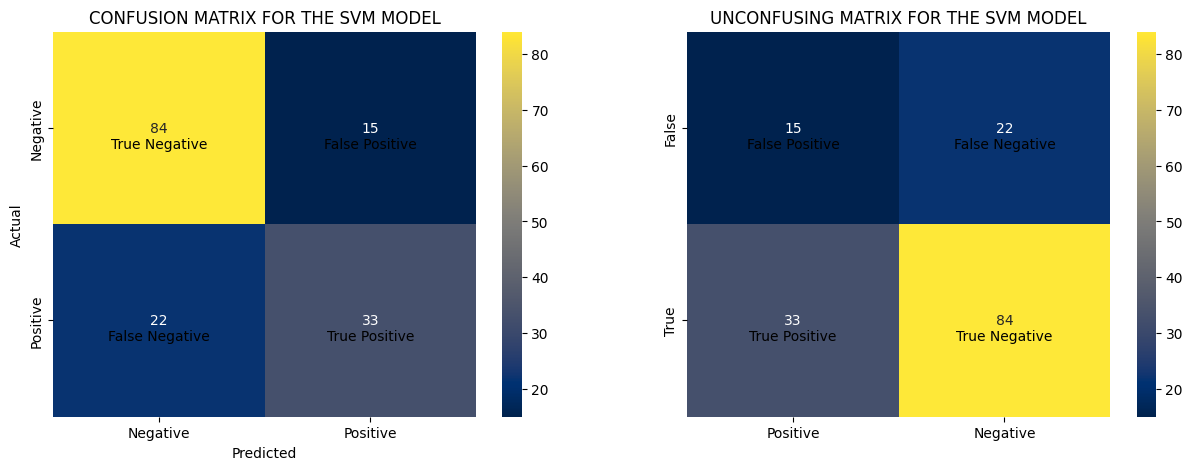

C:\Users\Spoon\AppData\Local\Temp\ipykernel_32660\3143736730.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Spoon\AppData\Local\Temp\ipykernel_32660\3402236529.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


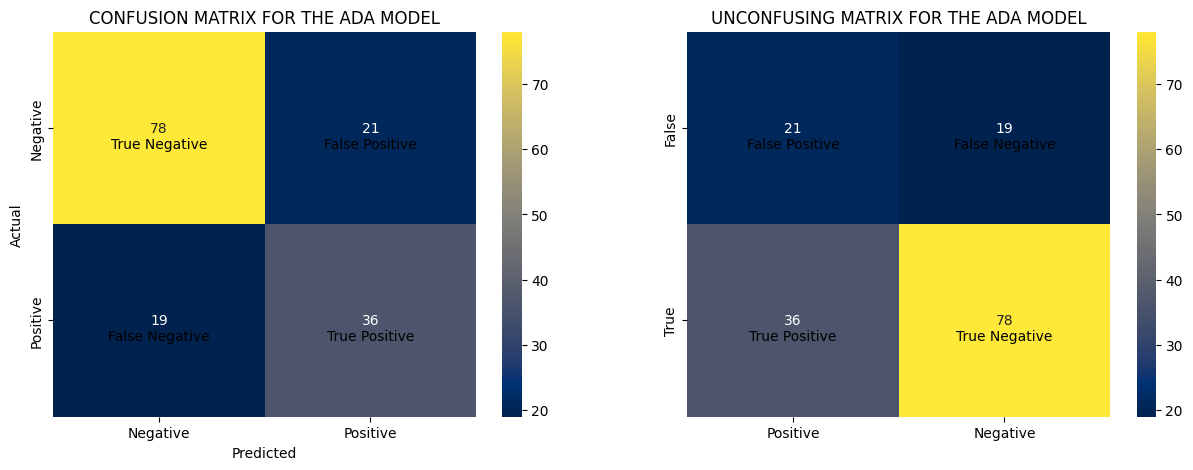

SVM Model Metrics
Accuracy:  0.7597402597402597
F1:  0.6407766990291262
FNR:  0.4
Recall:  0.6
Precision:  0.6875
Specificity:  0.8484848484848485
Confusion Matrix: 
 [[84 15]
 [22 33]]
ADA Model Metrics
Accuracy:  0.7402597402597403
F1:  0.6428571428571428
FNR:  0.34545454545454546
Recall:  0.6545454545454545
Precision:  0.631578947368421
Specificity:  0.7878787878787878
Confusion Matrix: 
 [[78 21]
 [19 36]]


In [ ]:

show_matrixs(new_svm.cm, 'SVM')


show_matrixs(new_ada.cm, 'ADA')

print("SVM Model Metrics")
new_svm.print()

print("ADA Model Metrics")
new_ada.print()